In [119]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
import seaborn as sns
import requests
from io import BytesIO

# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

In [120]:
# load in datasets
home_dir = Path().cwd().parent
df = pd.read_csv(
    home_dir / "cleaned-datasets" / "interpolated_economic_data.csv",
    engine="c", low_memory=False
)

df2 = pd.read_csv(
    home_dir / "cleaned-datasets" / "Cleaned_Meat_Stats_Meat_Production.csv",
    engine="c", low_memory=False
)

In [121]:
new_avg_unemployment = df.groupby(
    "date")[["unemployment_rate", "percent_error"]].mean().reset_index()

new_avg_unemployment['date'] = pd.to_datetime(
    new_avg_unemployment['date'], infer_datetime_format=True)
new_avg_unemployment

,date,unemployment_rate,percent_error
0,2010-01-01,6.841047,0.151923
1,2010-02-01,6.901016,0.151923
2,2010-03-01,6.961571,0.151923
3,2010-04-01,7.022721,0.151923
4,2010-05-01,7.084477,0.151923
...,...,...,...
151,2022-08-01,5.258827,0.161538
152,2022-09-01,5.236954,0.161538
153,2022-10-01,5.212853,0.161538
154,2022-11-01,5.186454,0.161538


In [122]:
red_meat_production = df2[df2['Type of Meat'] == 'Red Meat'].reset_index()
red_meat_production['date'] = pd.to_datetime(red_meat_production['Date'], infer_datetime_format=True)
red_meat_production = red_meat_production[['date', 'Production']]
red_meat_production

poultry_production = df2[df2['Type of Meat'] == 'Poultry'].reset_index()
poultry_production['date'] = pd.to_datetime(poultry_production['Date'], infer_datetime_format=True)
poultry_production = poultry_production[['date', 'Production']]
poultry_production

,date,Production
0,2010-01-01,3325.3
1,2010-02-01,3198.4
2,2010-03-01,3630.8
3,2010-04-01,3569.0
4,2010-05-01,3515.3
...,...,...
151,2022-08-01,4660.2
152,2022-09-01,4500.4
153,2022-10-01,4537.3
154,2022-11-01,4453.6


In [156]:
poultry_production.iloc[150]

date          2022-07-01 00:00:00
Production                 4172.8
Name: 150, dtype: object

In [142]:
mod_exog = sm.tsa.statespace.SARIMAX(
    endog=new_avg_unemployment['unemployment_rate'], exog=poultry_production['Production'], trend='c', order=(1, 1,0))
fit_res_exog = mod_exog.fit(disp=False)

mod_endog = sm.tsa.statespace.SARIMAX(
    endog=new_avg_unemployment['unemployment_rate'], trend='c', order=(1, 1, 1))
fit_res_endog = mod_endog.fit(disp=False)

print(fit_res_endog.summary())
print(fit_res_exog.summary())

                               SARIMAX Results                                
Dep. Variable:      unemployment_rate   No. Observations:                  156
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 794.558
Date:                Sun, 04 Aug 2024   AIC                          -1581.116
Time:                        14:57:53   BIC                          -1568.943
Sample:                             0   HQIC                         -1576.172
                                - 156                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.104e-05      0.000      0.204      0.839      -0.000       0.000
ar.L1          0.9906      0.005    180.880      0.000       0.980       1.001
ma.L1          0.9368      0.029     32.071      0.0

/Users/pramana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pramana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [146]:
res = mod_exog.filter(fit_res_exog.params)
predict = res.get_prediction()
predict.ci = predict.conf_int()

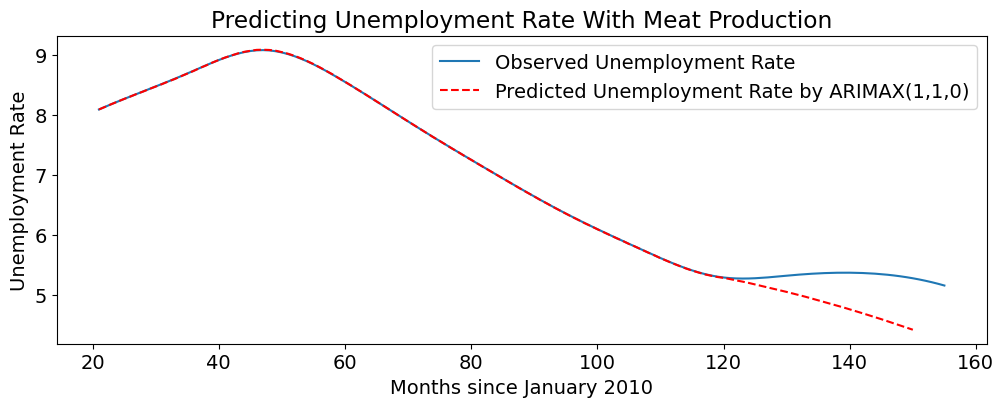

In [165]:
fig, ax = plt.subplots(figsize=(12, 4))
npre = 4

ax.set(title='Predicting Unemployment Rate With Meat Production',
       xlabel='Months since January 2010', ylabel='Unemployment Rate')

new_avg_unemployment.loc["2010-02-01":, 'unemployment_rate'].plot(x = 'date', ax=ax, style='-', label='Observed Unemployment Rate')

predict.predicted_mean.loc["2010-02-01":].plot(
    x='date', ax=ax, style='r--', label='Predicted Unemployment Rate by ARIMAX(1,1,0)')

legend = ax.legend(loc='upper right')
ci = predict.conf_int().loc['2010-01-01':]

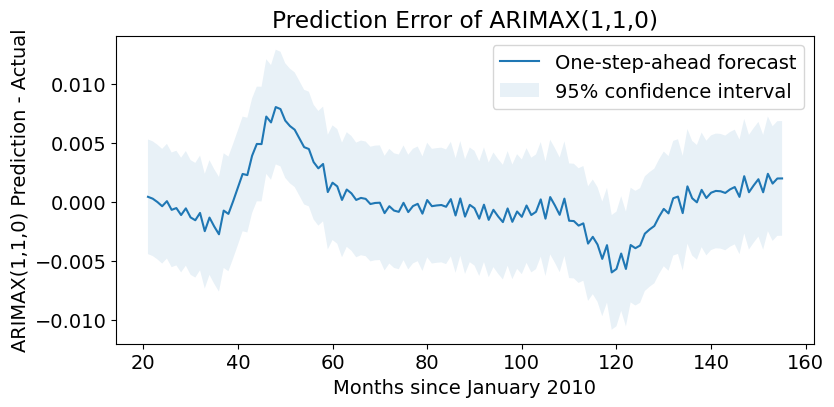

In [151]:
fig, ax = plt.subplots(figsize=(9, 4))
npre = 4
ax.set(title='Prediction Error of ARIMAX(1,1,0)', xlabel='Months since January 2010',
       ylabel='ARIMAX(1,1,0) Prediction - Actual')

predict_error = predict.predicted_mean - new_avg_unemployment['unemployment_rate']
predict_error.loc['2010-01-01':].plot(ax=ax, label='One-step-ahead forecast')
ci = predict.conf_int().loc['2010-01-01':].copy()
ci.iloc[:, 0] -= new_avg_unemployment['unemployment_rate'].loc['2010-01-01':]
ci.iloc[:, 1] -= new_avg_unemployment['unemployment_rate'].loc['2010-01-01':]
ax.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1],
                alpha=0.1, label='95% confidence interval')

ax.legend()

In [154]:
print(max(abs(predict_error[1:])))

0.13449631535056916


In [97]:
# np.asarray(new_avg_unemployment.iloc[:100][['date', 'unemployment_rate']])
# np.asarray(red_meat_production.iloc[:100])
new_avg_unemployment.iloc[1:100][['unemployment_rate']]
red_meat_production.iloc[1:]['Production']

1      7430.4
2      8515.9
3      7982.1
4      7422.2
5      8309.7
        ...  
151    9599.0
152    9276.7
153    9460.5
154    9530.7
155    8899.5
Name: Production, Length: 155, dtype: float64

/Users/pramana/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149]


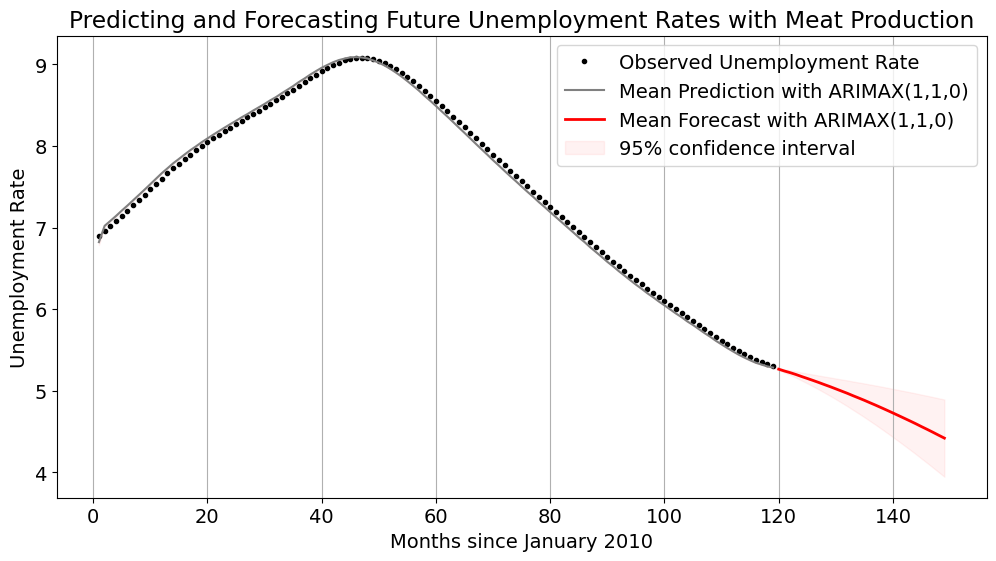

In [159]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
end_sample = 120
nforecast = 30

mod = sm.tsa.statespace.SARIMAX(
    endog=new_avg_unemployment.iloc[1:end_sample][['unemployment_rate']], 
    exog=red_meat_production.iloc[1:end_sample]['Production'],
    trend='c', order=(1, 1, 0))

res = mod.fit(disp=False)


predict = res.get_prediction(
    end=mod.nobs + nforecast, exog=red_meat_production.iloc[end_sample:end_sample+nforecast+1]['Production'])
idx = np.arange(1,len(predict.predicted_mean))
print(idx)
predict_ci = predict.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(12, 6))
ax.xaxis.grid()
ax.plot(new_avg_unemployment.iloc[1:end_sample]['unemployment_rate'], 'k.', label='Observed Unemployment Rate')

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[1:-nforecast], 'gray', label='Mean Prediction with ARIMAX(1,1,0)')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], label='Mean Forecast with ARIMAX(1,1,0)', color='r', linestyle='-', linewidth=2)
ax.fill_between(idx, predict_ci.iloc[1:, 0], predict_ci.iloc[1:, 1], color='r', alpha=0.05, label='95% confidence interval')

ax.set(title='Predicting and Forecasting Future Unemployment Rates with Meat Production',
       xlabel='Months since January 2010', ylabel='Unemployment Rate')
ax.legend()

In [163]:
print(predict.predicted_mean)
print(predict_ci.iloc[-1])
print(predict_ci.iloc[1])

1     -0.084248
2      6.822062
3      7.021982
4      7.082406
5      7.143531
         ...   
146    4.561282
147    4.527222
148    4.492077
149    4.455971
150    4.420633
Name: predicted_mean, Length: 150, dtype: float64
lower unemployment_rate    3.947424
upper unemployment_rate    4.893841
Name: 150, dtype: float64
lower unemployment_rate    6.786332
upper unemployment_rate    6.857792
Name: 2, dtype: float64
